# PREDICTIVE YIELD CURVE MODELING
<i>An Application of Principal Component Analysis to euro yield curves</i>
***
The term structure of interest rates (“yield curve”) is a representation that plots bonds of the same type (e.g. credit quality, sector) in terms of their prices, expressed as yields, over different maturity dates. This project sets out to study the yield curve dynamics in reduced dimensionality. In literature Principal Component Analysis (PCA) is a known application to this use case.

<u>After a successful yield curve decomposition the following topics will be tackled:</u>
- Supporting the interpretation of the first 3 principal components (PCs) in accordance with traditional (shift,slope,curvature) factors
- Testing out-of-sample fit for model yield curves, generated from reduced principal components set
- Derivation of non-linear stress scenarios for each component (1-month ahead 95% confidence)
- Testing predictability with an autoregressive timeseries model

The underlying data represents Euro area AAA government spot rate yield curves. They have been retrieved for a time horizon starting from 01-01-2015 to 31.12.2020 on a daily basis.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import StandardScaler

import os
import sys
root = os.environ['HOME']+"/work/pca-yield-curve-analytics/"
sys.path.append(root)



In [ ]:
def calc_rmse(a,b):
    se = (a-b)**2
    rmse = np.sqrt(se.mean(axis=1))
    return rmse

In [67]:
def rainbow(categories):
    """Generates a dictionary of color codes for each category."""
    c_scale = plt.cm.rainbow(np.linspace(0,1,len(categories)))
    c_dict = {}

    for i,c in zip(categories,c_scale):
        c_dict[i] = c
        
    return c_dict

In [68]:
maturities = ["3M", "1Y", "5Y", "10Y", "20Y"]

### Rates
***

In [69]:
df       = pd.read_csv("../assets/rates_clean.csv", index_col="DATE", parse_dates=["DATE"])
df_train = pd.read_csv("../assets/train.csv", index_col="DATE", parse_dates=["DATE"])
df_test  = pd.read_csv("../assets/test.csv", index_col="DATE", parse_dates=["DATE"])

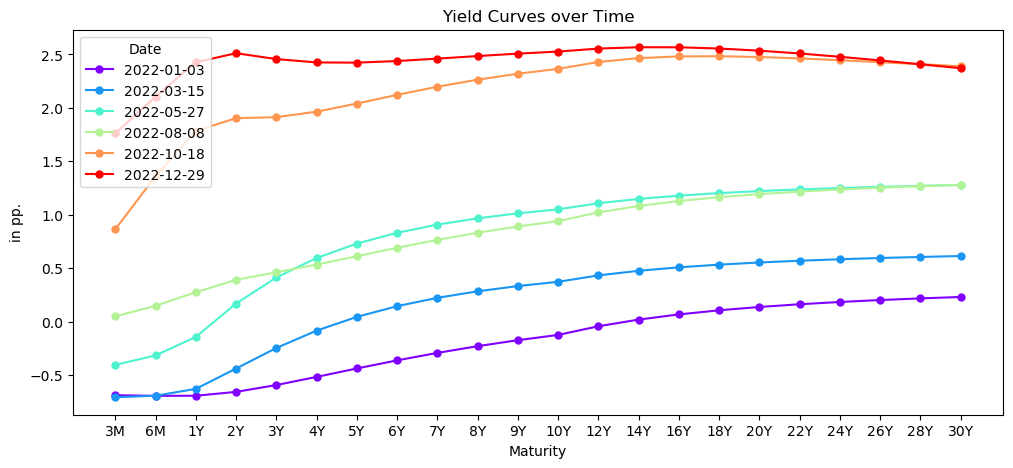

In [70]:
dates = df[::len(df)//5].index

# Depict yield curves per each observed year end
fig, ax = plt.subplots(figsize=(12,5))
color = rainbow(dates)

for i,j in enumerate(dates):
    ax.plot(df.loc[j], marker="o", markersize=5, c=color[j], label=j.date())

ax.set_title ("Yield Curves over Time")
ax.set_xlabel ("Maturity")
ax.set_ylabel ("in pp.")
ax.legend(title="Date", loc="upper left")

plt.show()

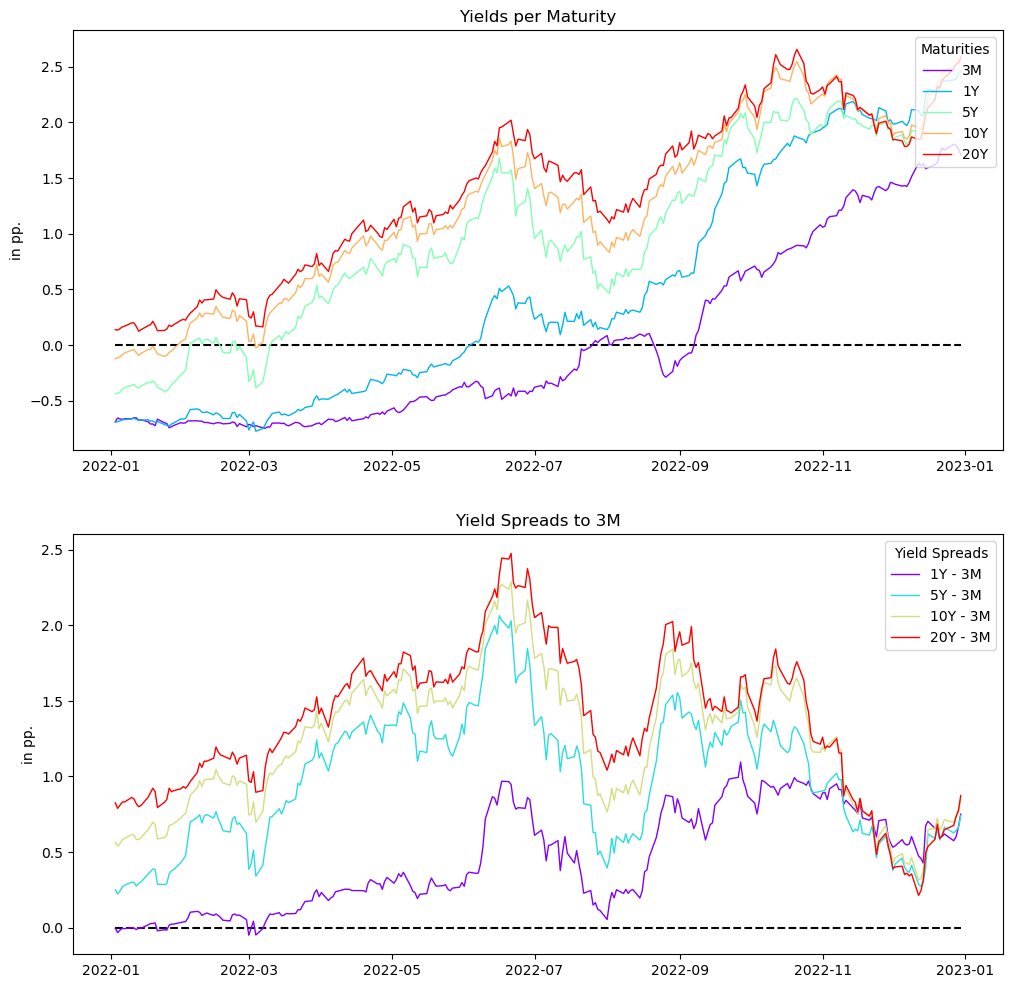

In [71]:
# Depicting yields for various maturities over time
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (12,12))

color_1 = rainbow(maturities)
color_2 = rainbow(maturities[1:])

# Subplot #1
for i in maturities: 
    ax1.plot (df[i], c=color_1[i], label=i, linewidth=1)

ax1.hlines(
    y=0, 
    xmin=min(df.index), 
    xmax=max(df.index), 
    colors="black", 
    linestyles="dashed"
)

# Subplot #2
for i in maturities[1:]: 
    plt.plot (df[i]-df.iloc[:,0], c=color_2[i], label= i+" - 3M", linewidth=1)
     
ax2.hlines(
    y=0,
    xmin=min(df.index), 
    xmax=max(df.index), 
    colors="black", 
    linestyles="dashed", 
    label=""
)

ax1.set_title ("Yields per Maturity")
ax2.set_title ("Yield Spreads to 3M")
ax1.set_ylabel ("in pp.")
ax2.set_ylabel ("in pp.")
ax1.legend(title = "Maturities", loc = "upper right")
ax2.legend(title = "Yield Spreads", loc = "upper right")
plt.show()

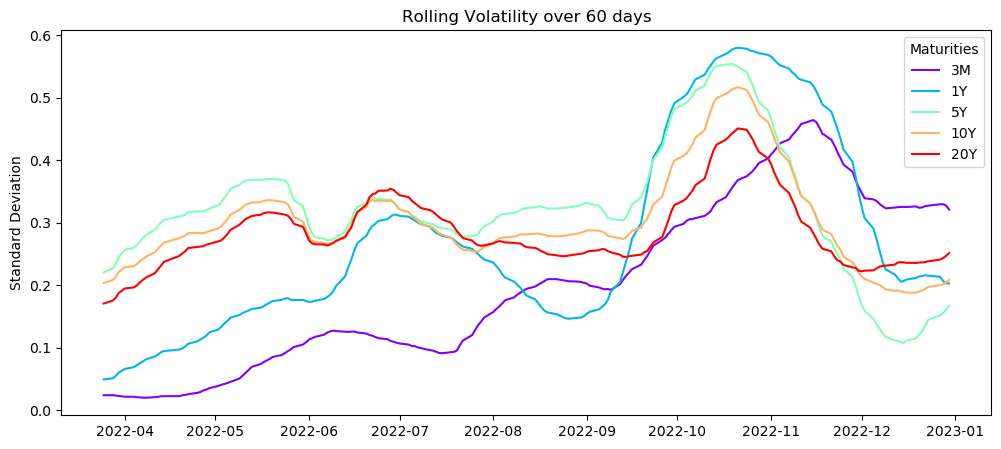

In [72]:
# Insert time window for rolling volatility (in units of previously defined frequency)
roll_window = 60
roll_vola = df.rolling(roll_window).std().iloc[roll_window-1:]

# Depicting rolling volatility for various maturities over time
fig, ax = plt.subplots(figsize=(12,5))

for i in maturities:
    ax.plot(roll_vola[i], c=color_1[i], label=i)

ax.set_title (f'Rolling Volatility over {roll_window} days')
ax.set_ylabel ("Standard Deviation")
ax.legend(title="Maturities", loc="upper right")
plt.show()

In [73]:
pca = joblib.load("../assets/pca.joblib")

### Eigenvectors & Eigenvalues
***

In [108]:
pca.__dict__.keys()

dict_keys(['df', 'maturities', 'k', 'cov_matr', 'idx', 'eig_vals', 'eig_vect', 'eig_vect_k', 'eig_scores', 'eig_scores_k', 'eig_vect_inv', 'eig_vect_inv_k', 'yields'])

In [123]:
eig_vectors    = pca.eig_vect_k
eig_values     = pca.eig_vals
eig_scores     = pca.eig_scores_k
pca_yields     = pca.yields
pca_yields_oos = pca.backtrans_oos(df_test)

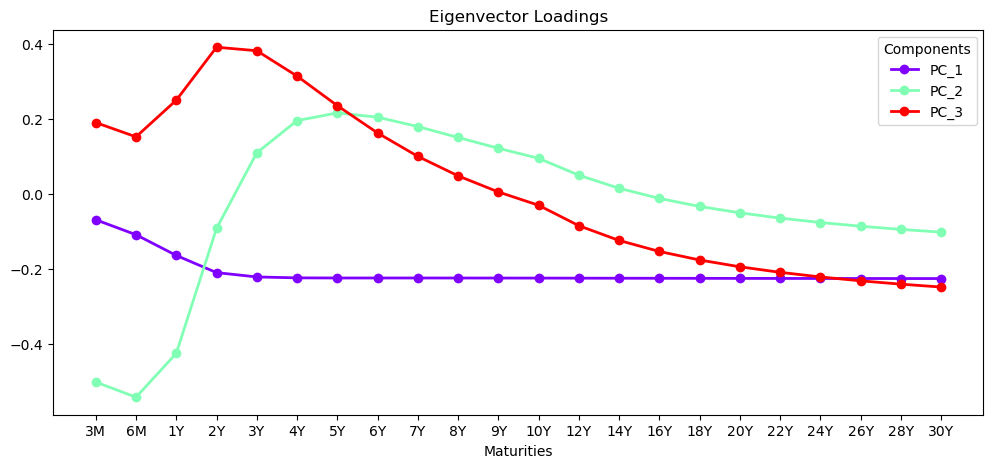

In [110]:
fig, ax = plt.subplots(figsize=(12,5))
color = rainbow(np.linspace(0,1,3)).values()

for (name, val), c in zip(eig_vectors.items(), color):
    ax.plot(val, c=c, label=name, linewidth=2, marker="o")

ax.set_title ("Eigenvector Loadings")
ax.set_xlabel ("Maturities")
ax.legend(title="Components")

plt.show()

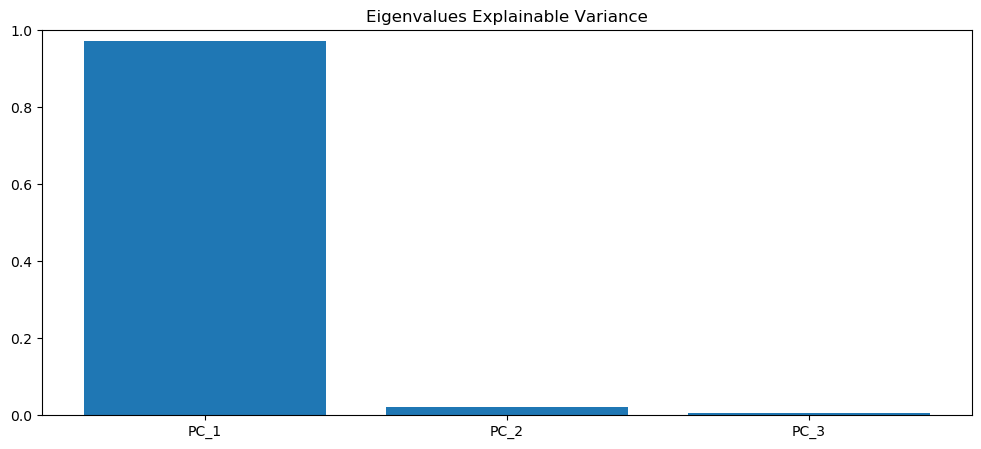

In [112]:
fig, ax = plt.subplots(figsize=(12,5))

ax.bar(
    eig_values.index[:pca.k], 
    eig_values["eig_val_rel"][:pca.k]
)

ax.set_ylim(0,1)
ax.set_title ("Eigenvalues Explainable Variance")
plt.show()

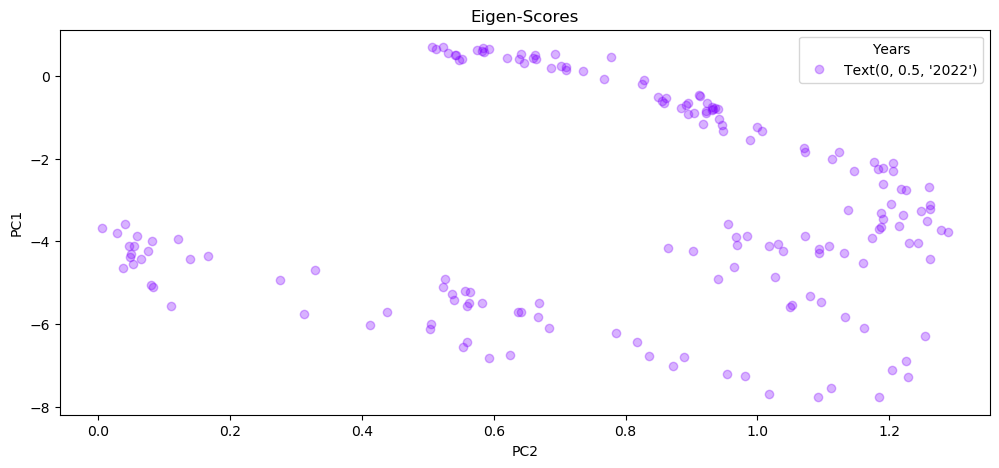

In [114]:
fig, ax = plt.subplots(figsize=(12,5))

color = rainbow(set(eig_scores.index.year))
eig_scores_by_year = eig_scores.groupby(eig_scores.index.year)

for year, data in eig_scores_by_year:
    ax.plot(
        data["PC_2"].values, 
        data["PC_1"].values, 
        c=color[year], 
        marker="o", 
        linestyle="", 
        alpha=0.3, 
        label=label
    )

ax.set_title("Eigen-Scores")
ax.set_ylabel("PC1")
ax.set_xlabel("PC2")
plt.legend(title="Years")
plt.show()

### Yield Curve Factors
***

In [115]:
scaler = StandardScaler()

# Scaled principal components
pc_1 = scaler.fit_transform(eig_scores["PC_1"].values.reshape(-1, 1))*-1
pc_2 = scaler.fit_transform(eig_scores["PC_2"].values.reshape(-1, 1))*-1
pc_3 = scaler.fit_transform(eig_scores["PC_3"].values.reshape(-1, 1))

# Classicla yield curve factors
lvl   = scaler.fit_transform(df_train["10Y"].values.reshape(-1, 1))
slope = scaler.fit_transform((df_train["10Y"] - df_train["6M"]).values.reshape(-1, 1))
curve = scaler.fit_transform((df_train["6M"] + df_train["10Y"] - 2*df_train["5Y"]).values.reshape(-1, 1))

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


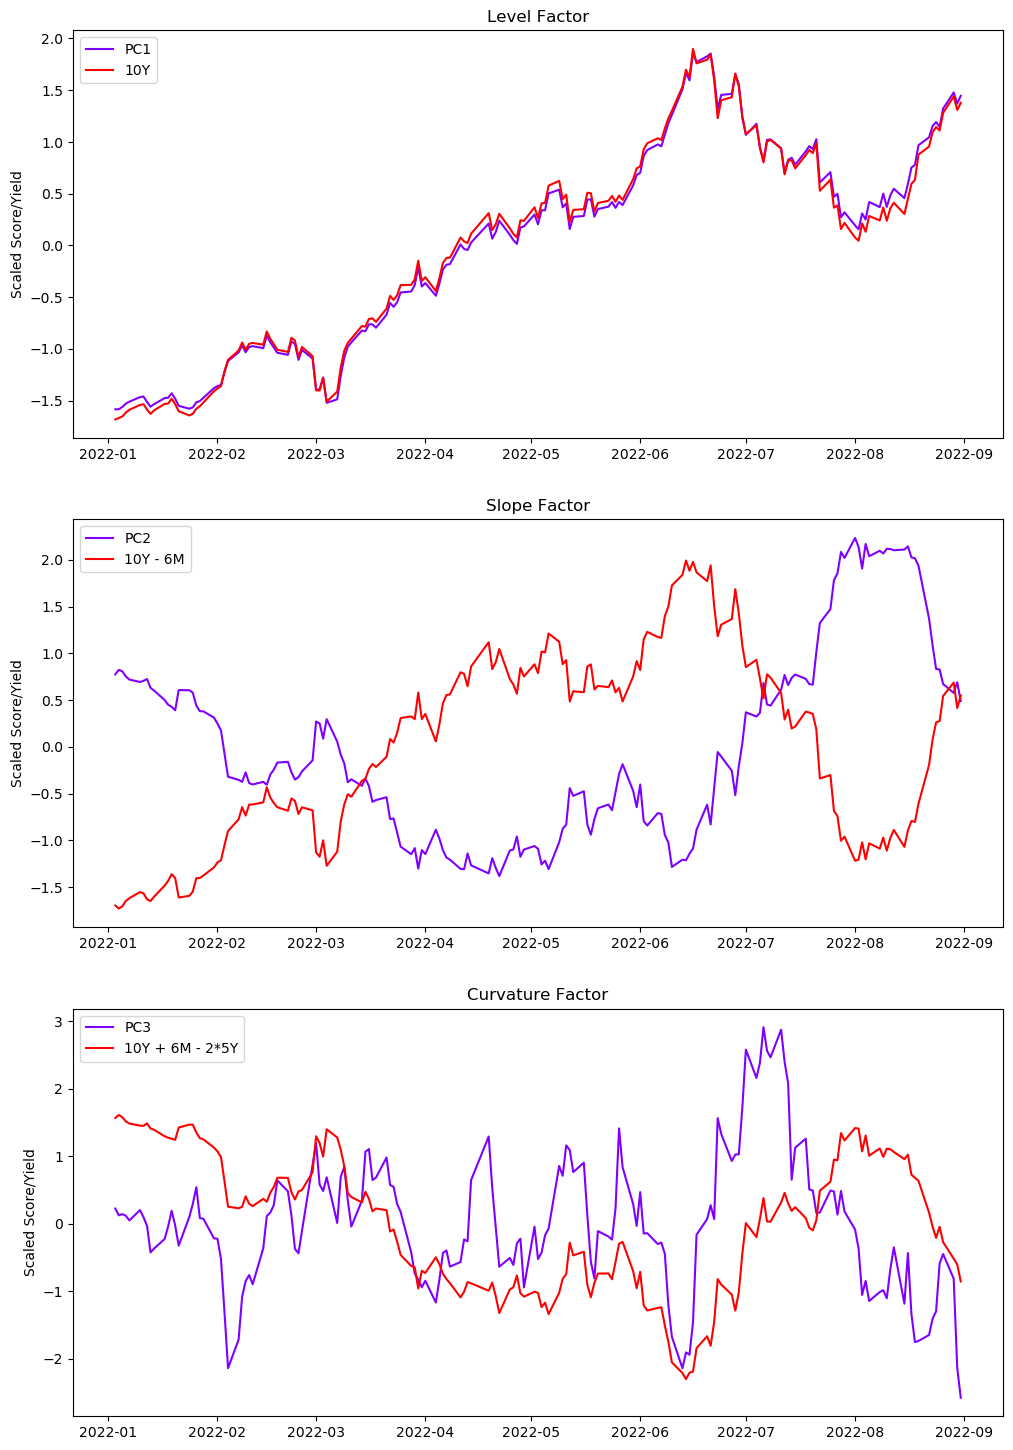

In [88]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,18))
colors = rainbow(["PC","YC"])

ax[0].plot(df_train.index, pc_1, label="PC1", c=colors["PC"])
ax[0].plot(df_train.index, lvl,  label="10Y", c=colors["YC"])
ax[1].plot(df_train.index, pc_2, label="PC2", c=colors["PC"])
ax[1].plot(df_train.index, slope,label="10Y - 6M", c=colors["YC"])
ax[2].plot(df_train.index, pc_3*-1, label="PC3", c=colors["PC"])
ax[2].plot(df_train.index, curve,label="10Y + 6M - 2*5Y", c=colors["YC"])

ax[0].set_title ("Level Factor")
ax[1].set_title ("Slope Factor")
ax[2].set_title ("Curvature Factor")

for i in range (3):
    ax[i].set_ylabel ("Scaled Score/Yield")
    ax[i].legend(loc = "upper left")

plt.show()

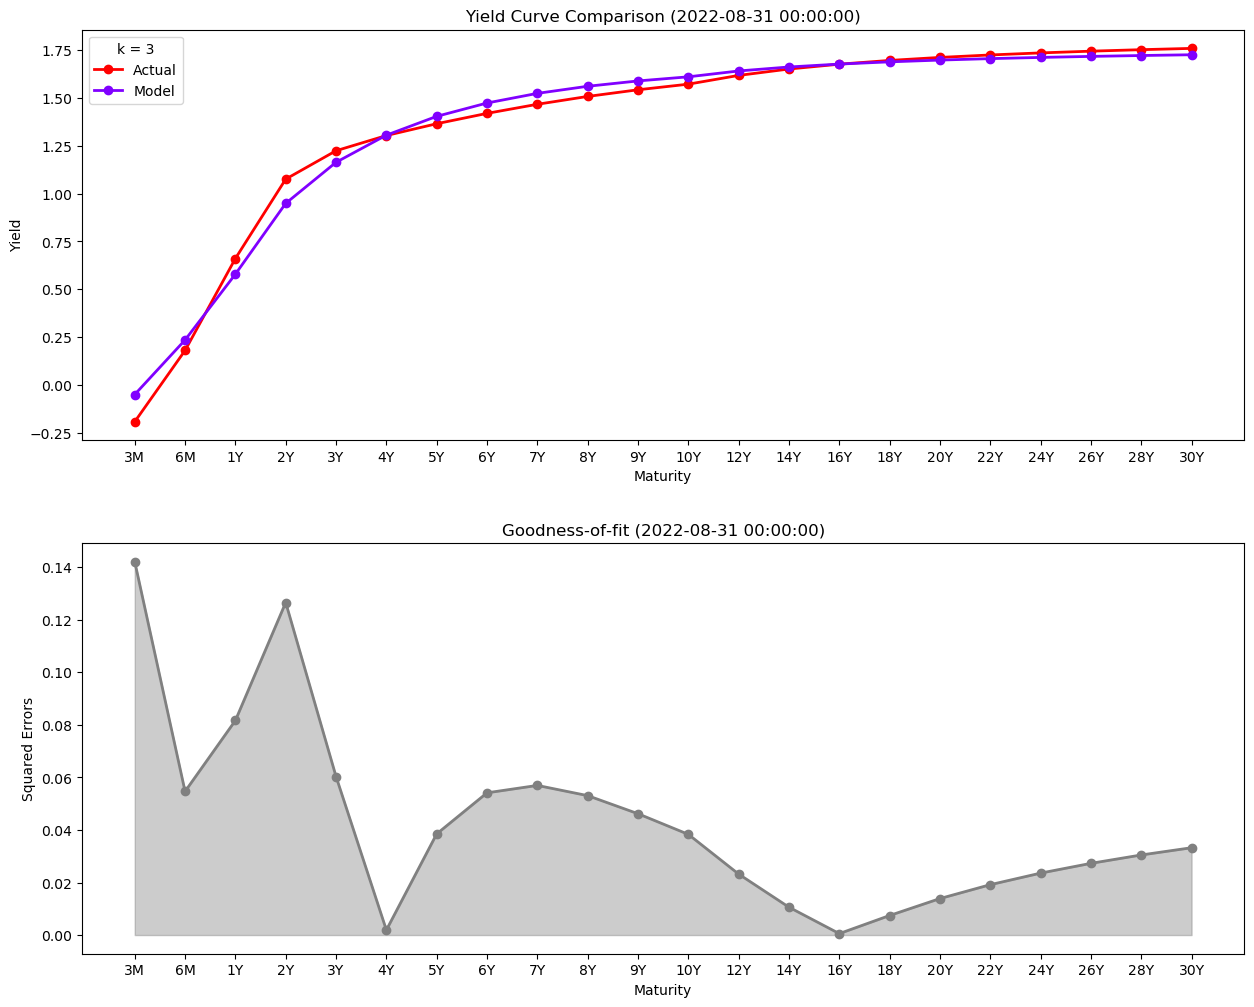

In [99]:
# Index of comparison date
idx = min(252, len(df_train))-1

x = pca_yields.iloc[idx,:]
y = df_train.iloc[idx,:]
rse = np.sqrt((x-y)**2)

fig, ax = plt.subplots(nrows=2, figsize = (15,12))

ax[0].plot(y, label="Actual", c=colors["YC"], linewidth=2, marker="o")
ax[0].plot(x, label="Model",  c=colors["PC"], linewidth=2, marker="o")

ax[1].plot(rse, c="grey", linewidth=2, marker="o")
ax[1].fill_between(x.index, rse, color="grey", alpha=0.4)

ax[0].set_xlabel("Maturity")
ax[0].set_ylabel("Yield")
ax[0].set_title(f"Yield Curve Comparison ({df_train.index[idx]})")

ax[1].set_xlabel("Maturity")
ax[1].set_ylabel("Squared Errors")
ax[1].set_title(f"Goodness-of-fit ({df_train.index[idx]})")

ax[0].legend(title = "k = "+str(pca.k))
plt.subplots_adjust(hspace=0.25)
plt.show()

In [124]:
rmse_train = calc_rmse(pca_yields, df_train)
rmse_test  = calc_rmse(pca_yields_oos, df_test)

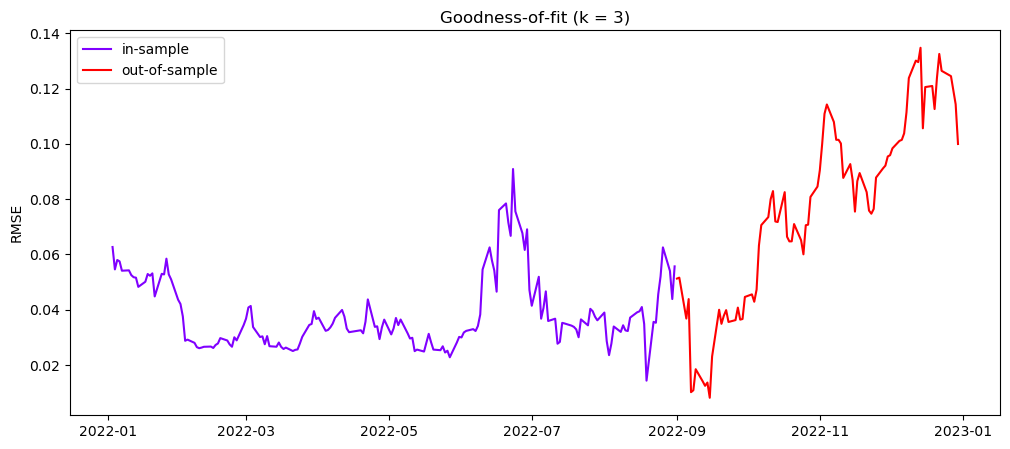

In [125]:
fig, ax = plt.subplots(figsize=(12,5))
color = rainbow(["in-sample","out-of-sample"])

ax.plot(rmse, c=color["in-sample"], label="in-sample")
ax.plot(rmse_oos, c=color["out-of-sample"], label="out-of-sample")

ax.set_title ("Goodness-of-fit (k = "+ str(pca.k) + ")")
ax.set_ylabel ("RMSE")
ax.legend()

plt.show()